In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import datetime

In [94]:
user_table = pd.read_csv("user_table.csv")
display(user_table.head())
display(user_table.info())

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


None

In [95]:
user_table.isnull().any()

user_id    False
city       False
country    False
lat        False
long       False
dtype: bool

In [96]:
test_results = pd.read_csv("test_results.csv",parse_dates=['timestamp'])
display(test_results.head())
test_results.info()
test_results.isnull().sum(axis=0)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

In [97]:
# check redundency all unique user_id
display(test_results.user_id.count())
display(len(test_results.user_id.unique()))
display(user_table.user_id.count())
display(len(user_table.user_id.unique()))

316800

316800

275616

275616

In [98]:
# merge the table
data = pd.merge(left=test_results,right=user_table,how = 'left',on='user_id')
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [99]:
# results that don't match 
# i.e.    price == 39 , test ==1  or price ==59, test==0 
display(data.loc[(data.test==0) & (data.price==59)].shape)
display(data.loc[(data.test==1) & (data.price==39)].shape)

(210, 12)

(155, 12)

In [100]:
# select the matched rows
data = data.loc[((data.price==39) & (data.test==0)) | ((data.price==59) &(data.test==1))]
data['revenue'] = data['converted']*data['price']
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


In [101]:
# average revenue by test
# $59 decreases conversion rate but increase revenue
group_df = data.groupby('test').agg({'price':'mean', 'converted':'mean'})
group_df['avg_gain']=group_df['price']*group_df['converted']
group_df.head()

,price,converted,avg_gain
test,,,
0,39,0.019900,0.776083
1,59,0.015555,0.917748


In [102]:
# total revenue by test 
rev = data.groupby('test').agg({'revenue':'sum'})
rev

,revenue
test,
0,157170
1,104548


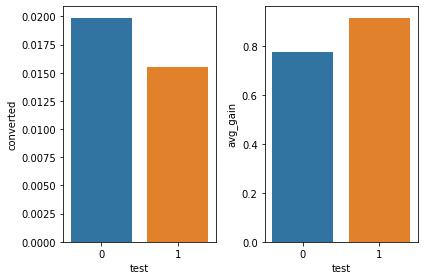

In [103]:
# plotting
fig,ax = plt.subplots(ncols=2)
for col in range(1,3):
    sns.barplot(x=group_df.index, y= group_df.iloc[:,col],ax=ax[col-1])
    plt.tight_layout()

In [104]:
# t-test
# H_0  exp group avg revenue <= ctr avg group revenue
# H_1 exp group avg revenue > ctr avg group revenue
ctr_val = data.loc[data['test']==0,'revenue'].values
exp_val = data.loc[data['test']==1, 'revenue'].values
print(ttest_ind(ctr_val,exp_val,axis=0,equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


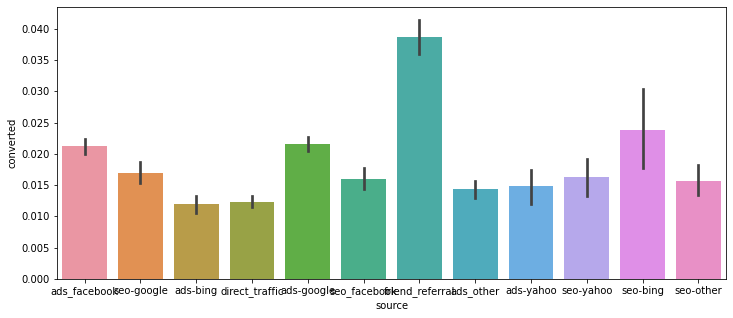

In [105]:
# reset_index adds an additional column of index [0,1,2,...] otherwise source is the index
data.groupby('source')['converted'].mean().reset_index()
fig,ax = plt.subplots(figsize=(12,5))
sns.barplot(x='source',y='converted',data=data,ax=ax)
plt.show()

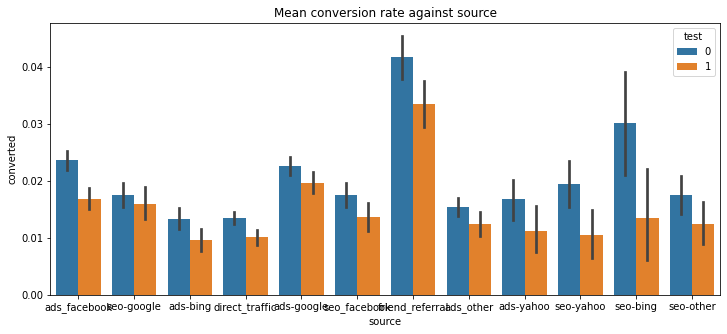

In [106]:
# visualization of source by test (0/1)
fig,ax = plt.subplots(figsize=(12,5))
sns.barplot(x='source',y='converted',data=data,hue='test',ax=ax)
ax.set_title('Mean conversion rate against source',fontsize=12)
plt.show()

In [107]:
data.groupby('device')['converted'].mean().reset_index()

,device,converted
0,mobile,0.018554
1,web,0.018023


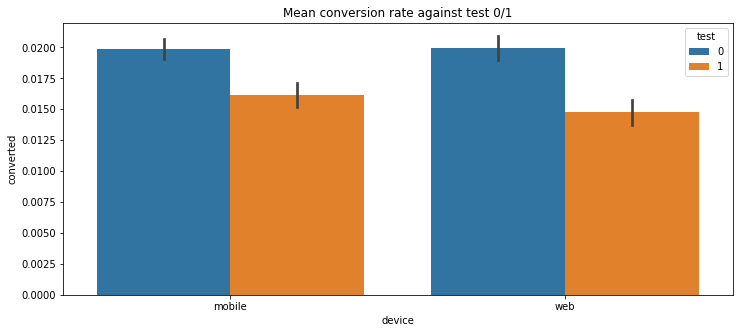

In [108]:
fig,ax = plt.subplots(figsize=(12,5))
sns.barplot(x='device',y='converted',data=data,hue='test',ax=ax)
ax.set_title('Mean conversion rate against test 0/1')
plt.show()

In [109]:
# operating system
data.groupby('operative_system')['converted'].mean().reset_index()

,operative_system,converted
0,android,0.014919
1,iOS,0.022328
2,linux,0.008232
3,mac,0.023987
4,other,0.012981
5,windows,0.016966


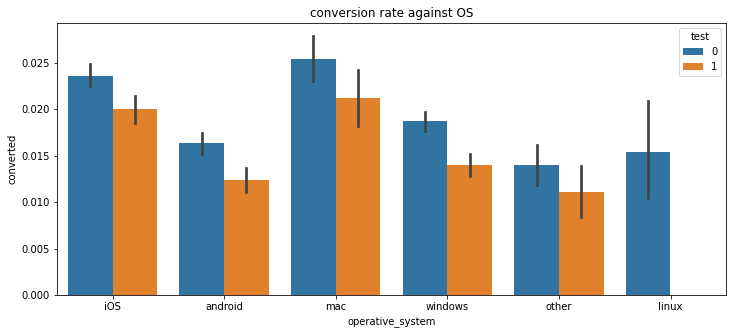

In [110]:
fig,ax = plt.subplots(figsize=(12,5))
sns.barplot(x = 'operative_system', y= 'converted', hue='test',data=data, ax=ax)
ax.set_title('conversion rate against OS')
plt.show()

In [111]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


In [125]:
data['datetime'] = (pd.to_datetime(data['timestamp'].replace(":60:",":59:", regex=True).replace(':60',':59',regex=True)) +  
              pd.Timedelta(1, 'min'))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [133]:
data['date_tuple'] = data['datetime'].apply(datetime.datetime.isocalendar)
data['weekofyear'] = 0

In [134]:
for i in len(data):
    data['weeko']

ValueError: Length of values (3) does not match length of index (316435)